In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import Lasso
from sklearn.model_selection import GroupKFold
from lightgbm import LGBMRegressor
from pprint import pprint;

import holidays
import dateutil.easter as easter
from colorama import Fore, Style, init;

In [2]:
sns.set({"axes.facecolor"       : "#ffffff",
         "figure.facecolor"     : "#ffffff",
         "axes.edgecolor"       : "#000000",
         "grid.color"           : "#ffffff",
         "font.family"          : ['Cambria'],
         "axes.labelcolor"      : "#000000",
         "xtick.color"          : "#000000",
         "ytick.color"          : "#000000",
         "grid.linewidth"       : 0.75,  
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : '#0099e6',
         'axes.titlesize'       : 8.5,
         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 7.5,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,        
        });
  
def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    "Prints color outputs using colorama using a text F-string";
    print(style + color + text + Style.RESET_ALL); 


In [3]:
sample_submission = pd.read_csv('./sample_submission.csv')
store = pd.read_csv('./store.csv')
test = pd.read_csv('./test.csv')
train = pd.read_csv('./train.csv')

In [4]:
PrintColor(f"\nFeatures\n");
pprint(train.columns, depth = 1, indent = 5);


Features

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')


In [5]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [6]:
train.describe(include='O')

,Date,StateHoliday
count,1017209,1017209
unique,942,5
top,2015-07-31,0
freq,1115,855087


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [8]:
train['StateHoliday'].value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

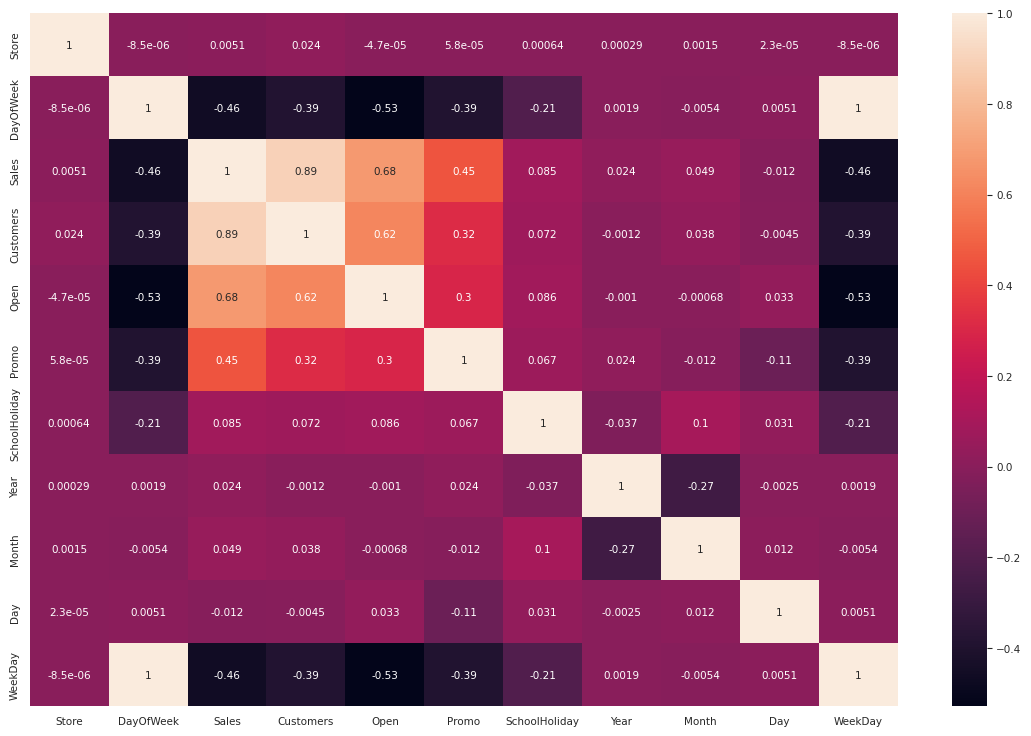

In [33]:
plt.figure(figsize=(14,9))
sns.heatmap(train.corr(), annot=True);

----------> Target distribution


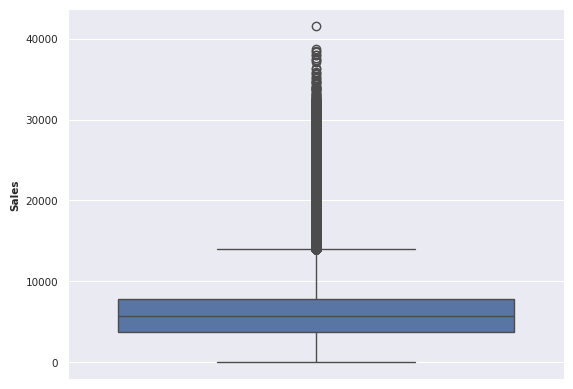

In [9]:
PrintColor('----------> Target distribution')
sns.boxplot(train['Sales']);

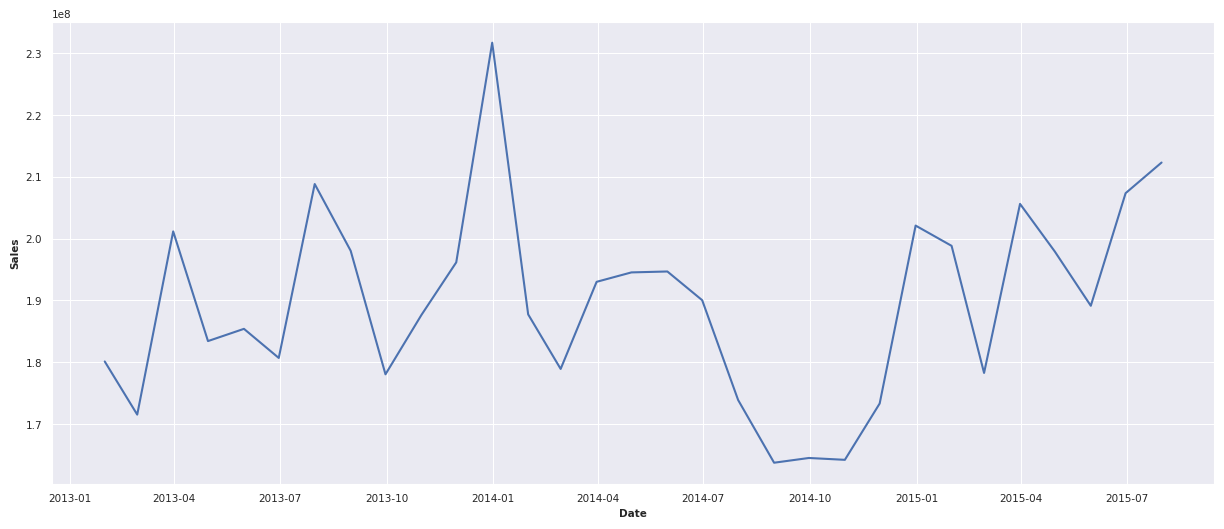

In [10]:
train['Date'] = pd.to_datetime(train['Date'])

monthly_sales = train.resample('M', on='Date')['Sales'].sum()

plt.figure(figsize=(15,6))
sns.lineplot(x = monthly_sales.index, y = monthly_sales)
plt.show();

---------> Smoothing Plot


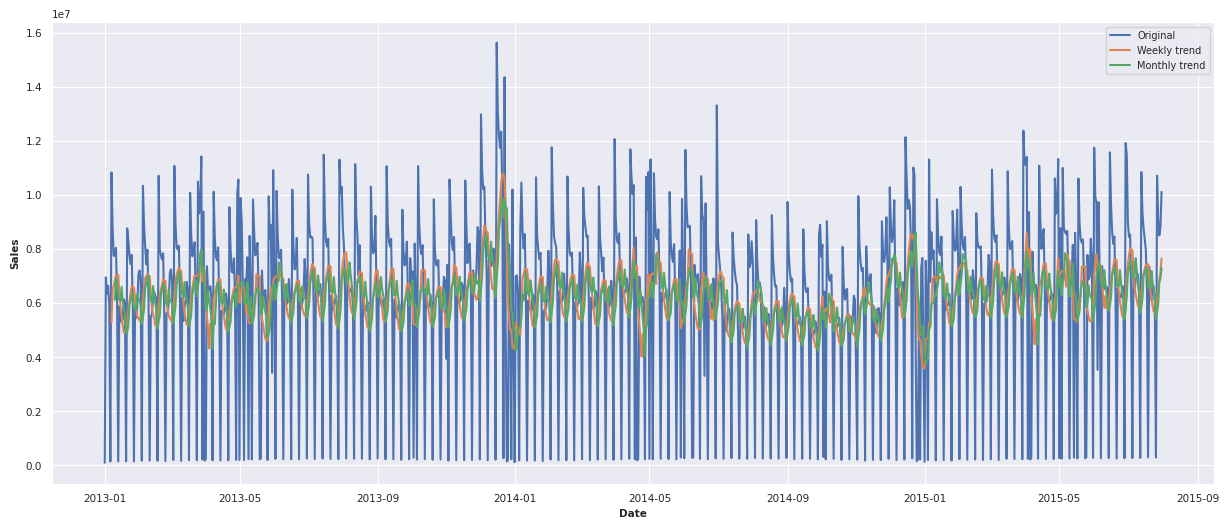

In [11]:
daily_sales = train.resample('D', on='Date')['Sales'].sum()

weekly_sales_trend = daily_sales.rolling(window=7).mean()
monthly_sales_trend = daily_sales.rolling(window=10).mean()
PrintColor('---------> Smoothing Plot')
plt.figure(figsize=(15,6))
sns.lineplot(x=daily_sales.index, y=daily_sales, label='Original')
sns.lineplot(x=weekly_sales_trend.index, y=weekly_sales_trend, label='Weekly trend')
sns.lineplot(x=monthly_sales_trend.index, y=monthly_sales_trend, label='Monthly trend')
plt.show();

-------> Annual Sales


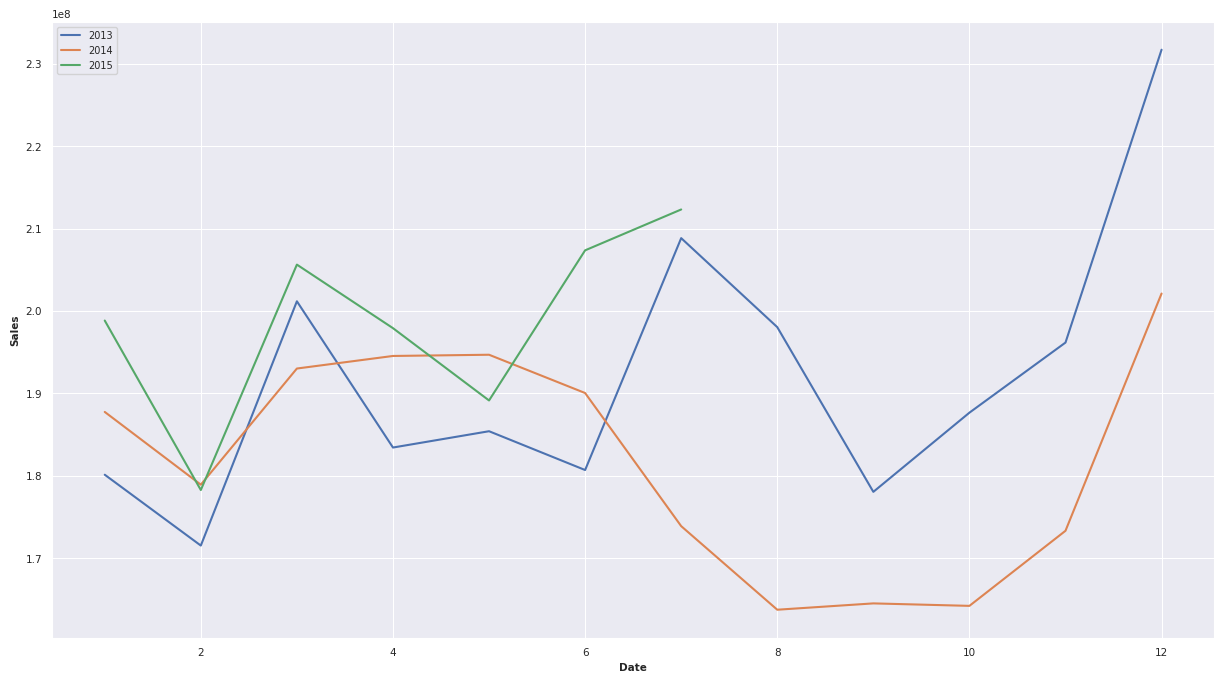

In [12]:
monthly_sales_year = train.resample('M', on='Date')['Sales'].sum().reset_index()
monthly_sales_year['year'] = monthly_sales_year['Date'].dt.year
plt.figure(figsize=(15,8))
PrintColor('-------> Annual Sales')
for year in sorted(monthly_sales_year['year'].unique()):
    year_data = monthly_sales_year[monthly_sales_year['year'] == year]
    sns.lineplot(x=year_data['Date'].dt.month, y=year_data['Sales'], label=year)
plt.show();

In [13]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

# Extract date info
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day
train['WeekDay'] = train['Date'].dt.dayofweek

test['Year'] = test['Date'].dt.year
test['Month'] = test['Date'].dt.month
test['Day'] = test['Date'].dt.day
test['WeekDay'] = test['Date'].dt.dayofweek

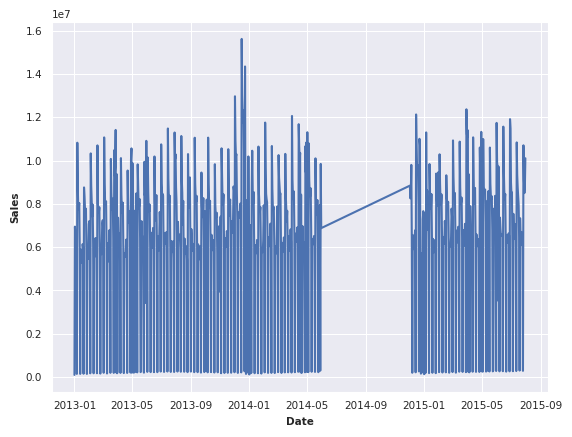

In [14]:
temp = train.loc[~((train['Date']>= "2014-06-01")&(train['Date'] <= "2014-12-01"))].copy()
train_agg = temp.groupby('Date')['Sales'].sum().reset_index()
sns.lineplot(data=train_agg, x='Date', y='Sales');

In [15]:
test_agg = test.groupby(["Date"]).first().reset_index().drop(['Id'], axis=1)
test_dates = test_agg[["Date"]]
test_agg[:5]

,Date,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekDay
0,2015-08-01,1,6,1.0,0,0,1,2015,8,1,5
1,2015-08-02,1,7,0.0,0,0,1,2015,8,2,6
2,2015-08-03,1,1,1.0,1,0,1,2015,8,3,0
3,2015-08-04,1,2,1.0,1,0,1,2015,8,4,1
4,2015-08-05,1,3,1.0,1,0,1,2015,8,5,2


In [16]:
y_train = train_agg['Sales']
X_train = train_agg.drop(['Sales'], axis=1)
X_test = test_agg

In [17]:
def feature_engineer(df):
    new_df = df.copy()
    new_df["Month"] = df["Date"].dt.month
    new_df["Month_sin"] = np.sin(new_df['Month'] * (2 * np.pi / 12))
    new_df["Month_cos"] = np.cos(new_df['Month'] * (2 * np.pi / 12))
    new_df["Day"] = df["Date"].dt.day
    new_df["Day_sin"] = np.sin(new_df['Day'] * (2 * np.pi / 12))
    new_df["DayOfWeek"] = df["Date"].dt.dayofweek
    new_df["DayOfWeek"] = new_df["DayOfWeek"].apply(lambda x: 0 if x<=3 else(1 if x==4 else (2 if x==5 else (3))))
    
    new_df["DayOfYear"] = df["Date"].dt.dayofyear
        
    new_df["Year"] = df["Date"].dt.year

    new_df = new_df.drop(columns=["Date","Month","Day", "DayOfYear"])

    return new_df

In [18]:
X_train = feature_engineer(X_train)
X_test = feature_engineer(X_test)

In [19]:
feat = ['Store', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'WeekDay']
X_test = X_test.drop(feat, axis=1)

In [20]:
X_train = X_train.reindex(sorted(X_train.columns), axis=1)
X_test = X_test.reindex(sorted(X_test.columns), axis=1)

In [21]:
def train_and_predict(X_train, y_train, X_test):
    preds_lst = []
    n_splits = 3
    kf = GroupKFold(n_splits=n_splits)
    scores = []
    train_scores = np.zeros(len(X_train))

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, groups=X_train.Year)):
        model = LGBMRegressor(n_estimators=2000, learning_rate=0.01, num_leaves=50, random_state=42, verbose=-1)
        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.iloc[train_idx]), columns=X_train.columns)
        X_val_scaled = pd.DataFrame(scaler.transform(X_train.iloc[val_idx]), columns=X_train.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

        model.fit(X_train_scaled, y_train.iloc[train_idx])
        preds_lst.append(model.predict(X_test_scaled))
        train_scores[val_idx] = model.predict(X_val_scaled)
        sc = model.score(X_val_scaled, y_train.iloc[val_idx])
        scores.append(sc)
        PrintColor(f"---------> Fold {fold}: Score = {sc}")

    mean_score = np.mean(scores)
    PrintColor(f"---------> MEAN SCORE: {mean_score}")
    return preds_lst, train_scores

preds_lst, train_scores = train_and_predict(X_train, y_train, X_test)
train_pred = pd.DataFrame()
train_pred['Date'] = train_agg['Date']
train_pred['Sales'] = train_scores

---------> Fold 0: Score = 0.5851050482391017
---------> Fold 1: Score = 0.6776555882971632
---------> Fold 2: Score = 0.6399160051303817
---------> MEAN SCORE: 0.6342255472222155


In [22]:
preds_df = pd.DataFrame(np.column_stack(preds_lst), columns=['2013', '2014', '2015'])
preds_df['Sales'] = preds_df.mean(axis=1)
test_dates["Sales"] = preds_df['Sales']

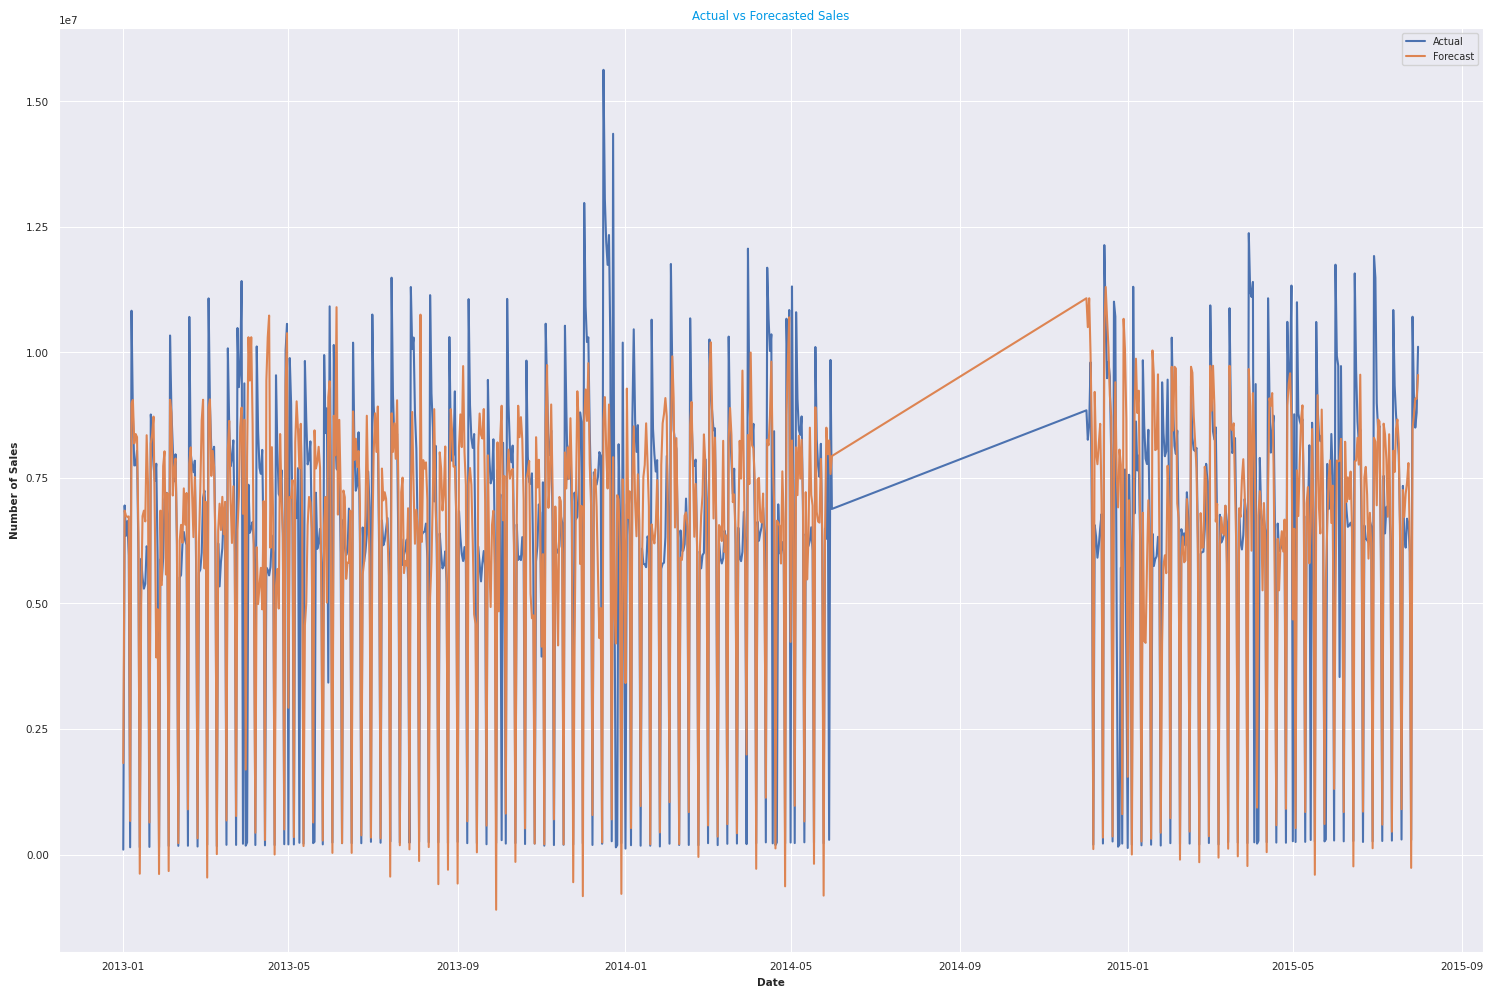

In [23]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=train_agg, x="Date", y="Sales", label='Actual')
sns.lineplot(data=train_pred, x='Date', y='Sales', label="Forecast")
plt.xlabel('Date')
plt.ylabel('Number of Sales')
plt.title('Actual vs Forecasted Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

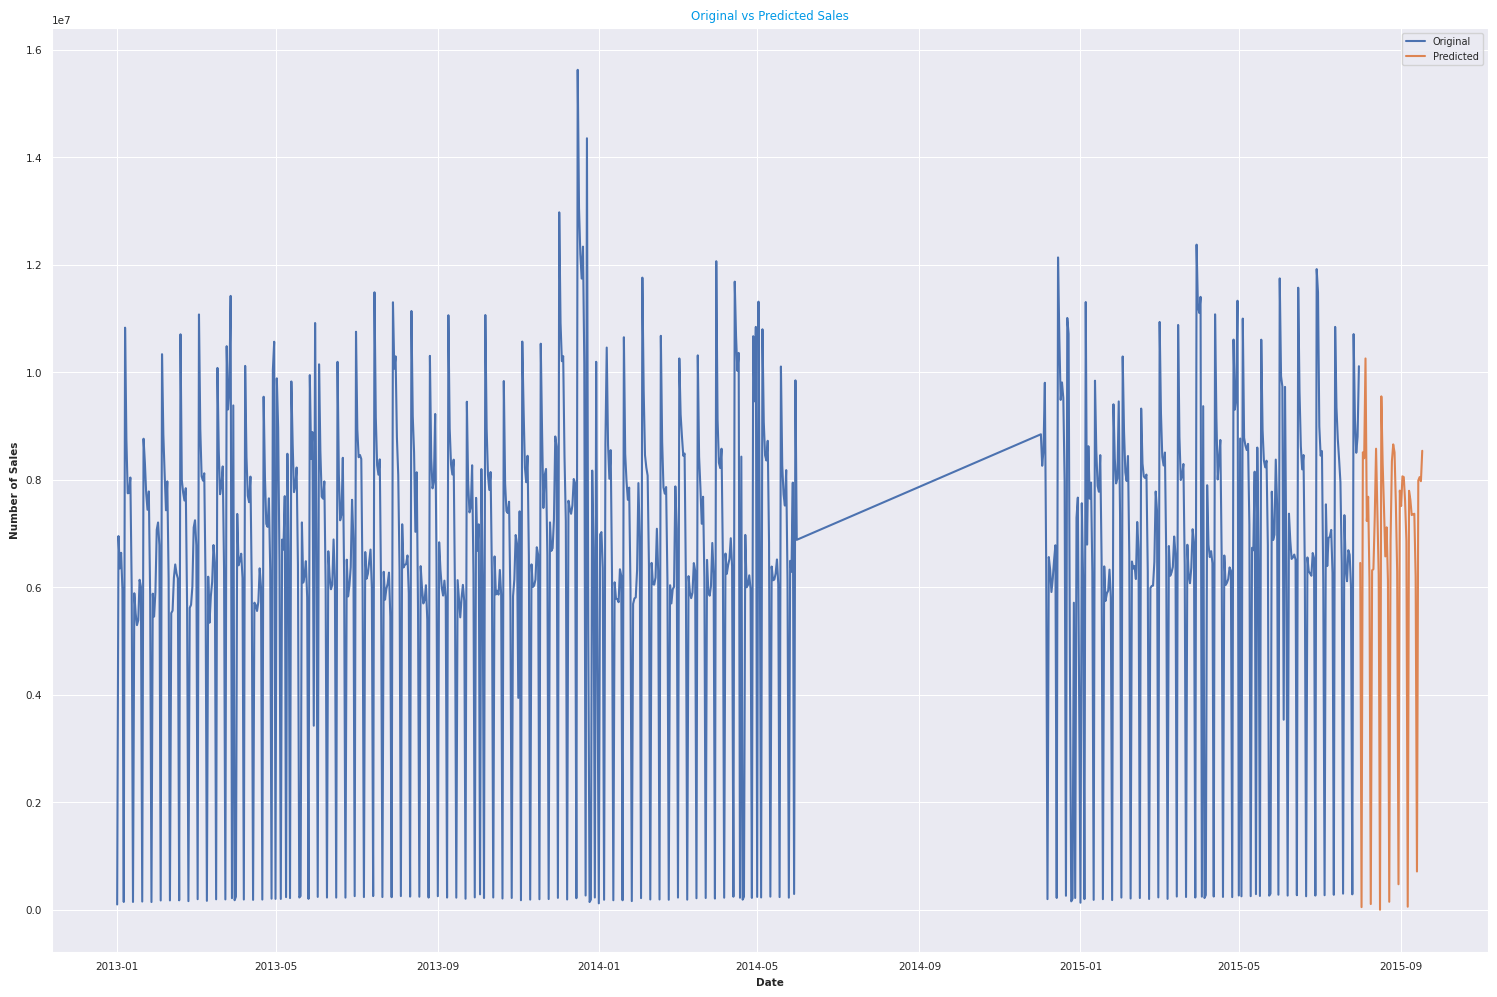

In [24]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=train_agg, x="Date", y="Sales", label='Original')
sns.lineplot(data=test_dates, x="Date", y="Sales", label='Predicted')
plt.xlabel('Date')
plt.ylabel('Number of Sales')
plt.title('Original vs Predicted Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
test_data = pd.merge(test, test_dates, how="left")

In [26]:
def disaggregate_forecast(df, original_data):

    new_df = df.copy()
    
    total_num_sold = original_data["Sales"].sum()

    stores_weights = original_data.groupby("Store")["Sales"].sum() / total_num_sold
                
    for store in stores_weights.index:
        new_df.loc[new_df["Store"] == store, "Sales"] *= stores_weights[store]
    

    new_df["Sales"] = new_df["Sales"].round()

    return new_df

In [27]:
store_weights = train.groupby("Store")["Sales"].sum()/train["Sales"].sum()

In [28]:
final_df = disaggregate_forecast(test_data,train)

In [29]:
submission = pd.read_csv("./sample_submission.csv")
submission["Sales"] = final_df["Sales"]

submission.head()
submission.to_csv('submission.csv', index = False)